# Image Representation

Using the `ImageFeatures` package to determine features or descriptors of an image. Later, will be used for object recognition, detection, matching, or overlaying.

## Using features and descriptors

To find areas that match between images, find commonalities. For cats, this might be ears and eyes.

### FAST Corner Detection

_Corner Detection_ is extracting intersection features from images. `ImageFeatures` implements "Features from Accelerated Segment Test" or FAST, as `fastcorners`. FAST scans for object corners, uses a circle of 16 pixels to evaluate if a point is a corner. Configured by 2 parameters

- Number of contiguous pixels (N)
- Threshold Value

Looking at applying this to cat images

┌ Info: Precompiling ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
└ @ Base loading.jl:1278


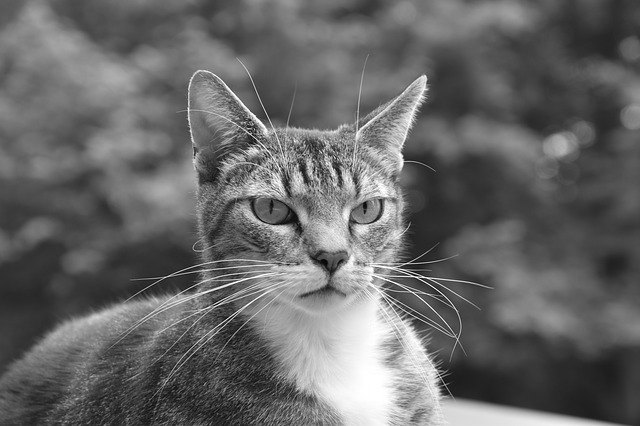

In [1]:
using Images, ImageFeatures
img = Gray.(load("../sample-images/cat-3417184_640.jpg"))

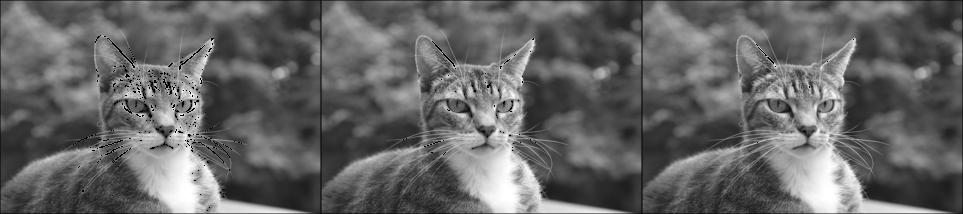

In [12]:
img_f = Float16.(restrict(img))
new_img = Gray.(hcat(
 img_f .* (.~fastcorners(img_f, 12, 0.15)),
 img_f .* (.~fastcorners(img_f, 12, 0.25)),
 img_f .* (.~fastcorners(img_f, 12, 0.35))
))

Here, the black dots represent corners identified by FAST. This can help identify areas that have content, for example in a newspaper example,

In [14]:
img = Gray.(load("../sample-images/newspaper-37782_640.png"))
img_f = Float16.(img)

new_img = Gray.(hcat(
 img_f,
 Float16.(img_f) .* (.~fastcorners(img_f, 12, 0.15))
))

LoadError: ArgumentError: No file exists at given path: ../sample-images/newspaper-37782_640.png